In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spopt
%run Wavenumbers_components.py
%run cvt.py
from cvt_bfgs import *
from shapely.geometry import Polygon
from shapely.geometry import Point

# Integrals implementation

In [74]:
from scipy.integrate import quad

def integrand_surface(t, p, q, normal):
    return np.dot(t*p + (1 - t)*q, normal)*np.linalg.norm(p - q)

def integrand_x2(t, p, q, normal):
    return np.dot((t*p + (1 - t)*q)**3, normal)*np.linalg.norm(p - q)

def integrand_x(t, p, q, normal, c):
    return np.dot(np.multiply(c, (t*p + (1 - t)*q)**2), normal)*np.linalg.norm(p - q)

def normale(polygon, p1, p2):
    P = Polygon(polygon)
    n1 = np.dot(np.array([[0, -1], [1, 0]]), p2 - p1) # Attention à la direction!: dans le sens des aiguilles d'une montre
    n2 = np.dot(np.array([[0, 1], [-1, 0]]), p2 - p1) # Attention à la direction!: dans le sens des aiguilles d'une montre
    middle = .5*(p1 + p2)
    epsilon = 0.001
    if P.contains(Point(middle + epsilon*n1)):
        n = n2/np.linalg.norm(n2)
    else:
        n = n1/np.linalg.norm(n1)
    return n

def area(polygon):
    Sm = 0
    for i in range(len(polygon) - 1):
        p1 = polygon[i]
        p2 = polygon[i + 1]
        n = normale(polygon, p1, p2)
        Sm = Sm + quad(integrand_surface, 0, 1, args = (p1, p2, n))[0]
    return 0.5*Sm

def centroid(polygon):
    Sx = 0
    Sy = 0
    cx = np.array([1, 0])
    cy = np.array([0, 1])
    for i in range(len(polygon) - 1):
        p1 = polygon[i]
        p2 = polygon[i + 1]
        n = normale(polygon, p1, p2)
        Sx = Sx + 0.5*quad(integrand_x, 0, 1, args = (p1, p2, n, cx))[0]
        Sy = Sy + 0.5*quad(integrand_x, 0, 1, args = (p1, p2, n, cy))[0]
    m = area(polygon)
    return np.array([Sx, Sy])/m

def integral_polygon2(polygon, seed):
    S = 0
    for i in range(len(polygon) - 1):
        p1 = polygon[i]
        p2 = polygon[i + 1]
        n = normale(polygon, p1, p2)
        S = S + 0.5*np.linalg.norm(seed)**2*quad(integrand_surface, 0, 1, args = (p1, p2, n))[0] - quad(integrand_x, 0, 1, args = (p1, p2, n, seed))[0] + 1/3*quad(integrand_x2, 0, 1, args =(p1, p2, n))[0]
    return S

def F2(X, domain):
    seeds, cells = voronoi_domain(X, domain)
    S = 0
    for i in range( len(cells) ):
        #cell_centered = cells[i] - seeds[i]
        S = S + integral_polygon(cells[i], lambda x: (x[0] - seeds[i, 0])**2 + (x[1] - seeds[i, 1])**2)
        #S = S + integral_polygon2(cells[i], seeds[i])
    return S

# Tests integrals formulae

In [88]:
def relative_error(a, b, order = 2):
    c = a - b
    A = np.linalg.norm(c, ord = order)
    B = np.linalg.norm(a, ord = order)
    return A/B

# n : number of seeds
def error_integrals(domain, X):
    
    seeds, regions = voronoi_domain(X, domain)
    
    error_m = []
    error_c = []
    
    for region in regions:
        P = Polygon(region)
        
        m_integral = np.array([area(region)])
        m_shapely = np.array([P.area])
        error_m.append( relative_error(m_integral, m_shapely) )
        
        c_integral = centroid(region)
        c_shapely = np.asarray(P.centroid)
        error_c.append( relative_error(c_integral, c_shapely) )
        
    error_m = np.array(error_m)
    error_m = np.linalg.norm(error_m, ord = np.inf)
    
    error_c = np.array(error_c)
    error_c = np.linalg.norm(error_c, ord = np.inf)
    
    F_integral = np.array([F(X, domain)])
    F_quadpy = np.array([F2(X, domain)])
    error_F = relative_error(F_integral, F_quadpy)
    
    return error_m, error_c, error_F, seeds.shape[0]

def inside(X, domain):
    P = Polygon(domain)
    points = [Point(p) for p in X]
    is_inside = [P.contains(p) for p in points]
    seeds = X[is_inside]
    
    return seeds

## triangle

In [89]:
triangle = np.array([[0,0], [.5, 1], [1, 0], [0,0]])
n = 100
rand = np.random.uniform(0, 1, size = (n, 2))
seeds = inside(rand, triangle)

error_integrals(triangle, seeds)

(7.567244961471669e-15, 3.0681226254713588e-15, 4.612066016051507e-14, 54)

## square

In [81]:
square = np.array([[0,0], [4,0], [4,4], [0,4], [0,0]])
n = 100
seeds = np.random.uniform(0, 4, size = (n, 2))
error_integrals(triangle, seeds)

(4.471529293079556e-15, 4.100261353072001e-15, 4.9889261666415914e-15, 100)

## hectagon

In [90]:
x = 3/np.sqrt(2)
y = 3

hectagon = np.array([[0, y], [x, x], [y, 0], [x, -x], [0, -y], [-x, -x], [-y, 0], [-x, x], [0, y]]) 
n = 100
c = list(Polygon(hectagon).centroid.coords)
angles = np.random.uniform(0, 2*np.pi, n)
radii = np.random.uniform(0, y, n)
rand = c + np.array([ [r*np.cos(theta), r*np.sin(theta)] for theta, r in zip(angles, radii) ])

seeds = inside(rand, hectagon)

shift = np.ones(2) # shift or the values will be so small that it will give 2 for example
error_integrals(hectagon + shift, seeds + shift)

(1.816441859849142e-15, 2.196021301386029e-15, 4.286098869545901e-15, 98)

## L

In [92]:
L = np.array([[0,0], [0, 1], [3, 1], [3, 2], [4, 2], [4, 0], [0,0]])
n = 400
rand = np.random.uniform(0, 4, size = (n, 2))

seeds = inside(rand, L)

# The evaluation of the function F using quadpy when the domain isn't convex is wrong
# so do not mind the third output
error_integrals(L, seeds)

(8.178740288362087e-15, 1.0797497103246473e-14, 1.418123015184603e-13, 129)

## W

In [84]:
# Data
x_diffraction_pt = np.array([5000, -3000]) # difraction point, fixed throughout the notebook

start = 0
stop = 10000

c0 = 2*np.pi # velocity of the medium
omega = 1 # it's f_0; is omega = f_0?
k0 = 2*np.pi*omega/c0*c0

# We compute the maximum angle \phi_max that \phi_s and \phi_r can take; will be useful for 
# later angular and circular arcs formulations of the wavenumber components 
s = np.array([start, 0])
ps = x_diffraction_pt - s
ps = ps/np.linalg.norm(ps)
phi_max = np.arccos(np.inner(ps, np.array([0, -1])))

W = domain_construction( np.array([ - phi_max, phi_max ]), k0)

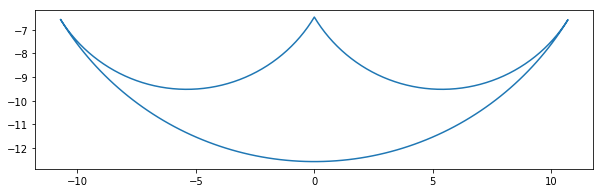

True

In [85]:
# Vizualization of the validity of the polygon
S = Polygon(np.array(W))
plt.figure(figsize = (10, 10))
ax = plt.gca()
ax.set_aspect('equal')
ax.plot(*S.exterior.xy)
plt.show()
S.is_valid

In [93]:
n = 400
rand = np.array([ np.random.uniform(-11, 11, size = n), np.random.uniform(-13, -5, size = n)]).T

seeds = inside(rand, W)

error_integrals(W, seeds)

(1.5067536033157078e-14, 1.609317001028527e-14, 0.09159828566815012, 119)